In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

import pickle
from statsmodels.stats.proportion import proportion_confint

### Analyzing CoT 0 for 4o, vision-preview, and humans

In [3]:
# Define all paths
gpt4o_cot0 = pd.read_csv('../gpt-4o/fewshot/results/chain_of_thought0/23_fewshot_results.csv')
gpt4o_cot1 = pd.read_csv('../gpt-4o/fewshot/results/chain_of_thought1/23_fewshot_results.csv')
gpt4o_cot2 = pd.read_csv('../gpt-4o/fewshot/results/chain_of_thought2/23_fewshot_results.csv')
gpt4o_cot3 = pd.read_csv('../gpt-4o/fewshot/results/chain_of_thought3/23_fewshot_results.csv')

gpt4visionpreview_cot0 = pd.read_csv('../gpt-4-vision-preview/fewshot/results/chain_of_thought0/23_fewshot_results.csv')
gpt4visionpreview_cot1 = pd.read_csv('../gpt-4-vision-preview/fewshot/results/chain_of_thought1/23_fewshot_results.csv')
gpt4visionpreview_cot2 = pd.read_csv('../gpt-4-vision-preview/fewshot/results/chain_of_thought2/23_fewshot_results.csv')
gpt4visionpreview_cot3 = pd.read_csv('../gpt-4-vision-preview/fewshot/results/chain_of_thought3/23_fewshot_results.csv')

claude35sonnet_cot0 = pd.read_csv('../claude-3.5-sonnet/results/chain_of_thought0/23_fewshot_results.csv')

internvl38b_cot0 = pd.read_csv('../internvl-38b/results/chain_of_thought0/InternVL2.5_38B_fewshot_results.csv')

qwen2vl72b_cot0 = pd.read_csv('../Qwen2-VL-72B/results/chain_of_thought0/Qwen2-VL-72B-Instruct-AWQ_fewshot_results.csv')


In [4]:
all_cot_logistic = pd.DataFrame()

gpt4o_results = [gpt4o_cot0, gpt4o_cot1, gpt4o_cot2, gpt4o_cot3]
gpt4visionpreview_results = [gpt4visionpreview_cot0, gpt4visionpreview_cot1, gpt4visionpreview_cot2, gpt4visionpreview_cot3]
claude35sonnet_results = [claude35sonnet_cot0]
internvl38b_results = [internvl38b_cot0]
qwenvl72b_results = [qwen2vl72b_cot0]

temp = [
    ('gpt-4o', gpt4o_results), 
    ('gpt-4-vision-preview', gpt4visionpreview_results), 
    ('claude-3-5-sonnet', claude35sonnet_results),
    ('InternVL2.5-38B', internvl38b_results),
    ('Qwen2-VL-72B', qwenvl72b_results)
]

for agent, results_set in temp:
    for i, cot in enumerate(results_set):
        print(f'Chain of Thought {i}')
        print(cot.columns)
        print( cot.problem.unique())
        print( cot.num_incontext.unique())
        print( cot.attempt.unique())

        # Check num_positive = num_negative on average across all problems
        display( cot.groupby(['num_incontext'])[['num_positive','num_negative']].mean())

        problem_by_num_incontext = cot.groupby(['problem','num_incontext'])[['accuracy','elapsed_time']].mean().reset_index()
        problem_by_num_incontext = problem_by_num_incontext.rename(columns = {'elapsed_time': 'mean_elapsed_time_over_10_attempts'})

        # Relevant columns
        cols = ['problem','num_incontext','attempt','accuracy']
        cot_logistic = cot[cols]
        cot_logistic['agent'] = agent
        cot_logistic['cot'] = f'Chain of Thought {i}'

        # Get first 10 attempts of each num_incontext and problem, if accidentally ran more than 10
        def max_10(group):
            return group.drop_duplicates(subset='attempt', keep='first')
        if i != 1:
            cot_logistic = cot_logistic.groupby(['problem','num_incontext']).apply(max_10).reset_index(drop = True)
        display(cot_logistic)

        # Append
        all_cot_logistic = pd.concat([all_cot_logistic, cot_logistic])

Chain of Thought 0
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.556522,1.443478
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,gpt-4o,Chain of Thought 0
1,1,1,2,1,gpt-4o,Chain of Thought 0
2,1,1,3,1,gpt-4o,Chain of Thought 0
3,1,1,4,0,gpt-4o,Chain of Thought 0
4,1,1,5,0,gpt-4o,Chain of Thought 0
...,...,...,...,...,...,...
2065,23,9,6,0,gpt-4o,Chain of Thought 0
2066,23,9,7,1,gpt-4o,Chain of Thought 0
2067,23,9,8,0,gpt-4o,Chain of Thought 0
2068,23,9,9,0,gpt-4o,Chain of Thought 0


Chain of Thought 1
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.556522,1.443478
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,gpt-4o,Chain of Thought 1
1,1,1,2,1,gpt-4o,Chain of Thought 1
2,1,1,3,1,gpt-4o,Chain of Thought 1
3,1,1,4,0,gpt-4o,Chain of Thought 1
4,1,1,5,1,gpt-4o,Chain of Thought 1
...,...,...,...,...,...,...
2065,23,9,6,1,gpt-4o,Chain of Thought 1
2066,23,9,7,1,gpt-4o,Chain of Thought 1
2067,23,9,8,1,gpt-4o,Chain of Thought 1
2068,23,9,9,0,gpt-4o,Chain of Thought 1


Chain of Thought 2
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.556522,1.443478
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,gpt-4o,Chain of Thought 2
1,1,1,2,1,gpt-4o,Chain of Thought 2
2,1,1,3,1,gpt-4o,Chain of Thought 2
3,1,1,4,0,gpt-4o,Chain of Thought 2
4,1,1,5,0,gpt-4o,Chain of Thought 2
...,...,...,...,...,...,...
2065,23,9,6,1,gpt-4o,Chain of Thought 2
2066,23,9,7,1,gpt-4o,Chain of Thought 2
2067,23,9,8,0,gpt-4o,Chain of Thought 2
2068,23,9,9,0,gpt-4o,Chain of Thought 2


Chain of Thought 3
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.556522,1.443478
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,gpt-4o,Chain of Thought 3
1,1,1,2,1,gpt-4o,Chain of Thought 3
2,1,1,3,1,gpt-4o,Chain of Thought 3
3,1,1,4,0,gpt-4o,Chain of Thought 3
4,1,1,5,0,gpt-4o,Chain of Thought 3
...,...,...,...,...,...,...
2065,23,9,6,1,gpt-4o,Chain of Thought 3
2066,23,9,7,1,gpt-4o,Chain of Thought 3
2067,23,9,8,0,gpt-4o,Chain of Thought 3
2068,23,9,9,0,gpt-4o,Chain of Thought 3


Chain of Thought 0
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.549356,1.450644
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,gpt-4-vision-preview,Chain of Thought 0
1,1,1,2,0,gpt-4-vision-preview,Chain of Thought 0
2,1,1,3,1,gpt-4-vision-preview,Chain of Thought 0
3,1,1,4,1,gpt-4-vision-preview,Chain of Thought 0
4,1,1,5,1,gpt-4-vision-preview,Chain of Thought 0
...,...,...,...,...,...,...
2065,23,9,6,0,gpt-4-vision-preview,Chain of Thought 0
2066,23,9,7,1,gpt-4-vision-preview,Chain of Thought 0
2067,23,9,8,1,gpt-4-vision-preview,Chain of Thought 0
2068,23,9,9,0,gpt-4-vision-preview,Chain of Thought 0


Chain of Thought 1
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.556522,1.443478
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,gpt-4-vision-preview,Chain of Thought 1
1,1,1,2,0,gpt-4-vision-preview,Chain of Thought 1
2,1,1,3,1,gpt-4-vision-preview,Chain of Thought 1
3,1,1,4,1,gpt-4-vision-preview,Chain of Thought 1
4,1,1,5,1,gpt-4-vision-preview,Chain of Thought 1
...,...,...,...,...,...,...
2065,9,9,5,0,gpt-4-vision-preview,Chain of Thought 1
2066,9,9,6,0,gpt-4-vision-preview,Chain of Thought 1
2067,9,9,7,0,gpt-4-vision-preview,Chain of Thought 1
2068,9,9,8,1,gpt-4-vision-preview,Chain of Thought 1


Chain of Thought 2
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.556522,1.443478
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,gpt-4-vision-preview,Chain of Thought 2
1,1,1,2,0,gpt-4-vision-preview,Chain of Thought 2
2,1,1,3,1,gpt-4-vision-preview,Chain of Thought 2
3,1,1,4,1,gpt-4-vision-preview,Chain of Thought 2
4,1,1,5,1,gpt-4-vision-preview,Chain of Thought 2
...,...,...,...,...,...,...
2065,23,9,6,0,gpt-4-vision-preview,Chain of Thought 2
2066,23,9,7,1,gpt-4-vision-preview,Chain of Thought 2
2067,23,9,8,1,gpt-4-vision-preview,Chain of Thought 2
2068,23,9,9,0,gpt-4-vision-preview,Chain of Thought 2


Chain of Thought 3
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.556522,1.443478
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,gpt-4-vision-preview,Chain of Thought 3
1,1,1,2,0,gpt-4-vision-preview,Chain of Thought 3
2,1,1,3,1,gpt-4-vision-preview,Chain of Thought 3
3,1,1,4,1,gpt-4-vision-preview,Chain of Thought 3
4,1,1,5,1,gpt-4-vision-preview,Chain of Thought 3
...,...,...,...,...,...,...
2065,23,9,6,1,gpt-4-vision-preview,Chain of Thought 3
2066,23,9,7,1,gpt-4-vision-preview,Chain of Thought 3
2067,23,9,8,1,gpt-4-vision-preview,Chain of Thought 3
2068,23,9,9,0,gpt-4-vision-preview,Chain of Thought 3


Chain of Thought 0
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.556522,1.443478
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,claude-3-5-sonnet,Chain of Thought 0
1,1,1,2,0,claude-3-5-sonnet,Chain of Thought 0
2,1,1,3,1,claude-3-5-sonnet,Chain of Thought 0
3,1,1,4,1,claude-3-5-sonnet,Chain of Thought 0
4,1,1,5,1,claude-3-5-sonnet,Chain of Thought 0
...,...,...,...,...,...,...
2065,23,9,6,1,claude-3-5-sonnet,Chain of Thought 0
2066,23,9,7,0,claude-3-5-sonnet,Chain of Thought 0
2067,23,9,8,0,claude-3-5-sonnet,Chain of Thought 0
2068,23,9,9,1,claude-3-5-sonnet,Chain of Thought 0


Chain of Thought 0
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.556522,1.443478
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,InternVL2.5-38B,Chain of Thought 0
1,1,1,2,1,InternVL2.5-38B,Chain of Thought 0
2,1,1,3,1,InternVL2.5-38B,Chain of Thought 0
3,1,1,4,1,InternVL2.5-38B,Chain of Thought 0
4,1,1,5,1,InternVL2.5-38B,Chain of Thought 0
...,...,...,...,...,...,...
2065,23,9,6,1,InternVL2.5-38B,Chain of Thought 0
2066,23,9,7,1,InternVL2.5-38B,Chain of Thought 0
2067,23,9,8,1,InternVL2.5-38B,Chain of Thought 0
2068,23,9,9,1,InternVL2.5-38B,Chain of Thought 0


Chain of Thought 0
Index(['Unnamed: 0', 'condition', 'problem', 'num_incontext', 'attempt',
       'incontext_images', 'query_image', 'query_category', 'num_positive',
       'num_negative', 'convo', 'selected_category', 'accuracy',
       'raw_response', 'elapsed_time'],
      dtype='object')
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1 2 3 4 5 6 7 8 9]
[ 1  2  3  4  5  6  7  8  9 10]


,num_positive,num_negative
num_incontext,,
1,0.513043,0.486957
2,1.034783,0.965217
3,1.556522,1.443478
4,1.991304,2.008696
5,2.513043,2.486957
6,3.034783,2.965217
7,3.282609,3.717391
8,4.030435,3.969565
9,4.586957,4.413043


/tmp/ipykernel_1262856/4027438040.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['agent'] = agent
/tmp/ipykernel_1262856/4027438040.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cot_logistic['cot'] = f'Chain of Thought {i}'


,problem,num_incontext,attempt,accuracy,agent,cot
0,1,1,1,1,Qwen2-VL-72B,Chain of Thought 0
1,1,1,2,1,Qwen2-VL-72B,Chain of Thought 0
2,1,1,3,0,Qwen2-VL-72B,Chain of Thought 0
3,1,1,4,0,Qwen2-VL-72B,Chain of Thought 0
4,1,1,5,0,Qwen2-VL-72B,Chain of Thought 0
...,...,...,...,...,...,...
2065,23,9,6,1,Qwen2-VL-72B,Chain of Thought 0
2066,23,9,7,1,Qwen2-VL-72B,Chain of Thought 0
2067,23,9,8,1,Qwen2-VL-72B,Chain of Thought 0
2068,23,9,9,0,Qwen2-VL-72B,Chain of Thought 0


### Human data

In [5]:
import glob

# Grab filenames
fnames = sorted(glob.glob('../humans/data_ours/*.csv'))
print('There are', len(fnames), 'participants in all of Exp 3')

def process(df):
    relevant_cols = [
        'Participant #', 
        'current_problem_num', 
        'accuracy', 
        'trials.thisTrialN',
        'expName'
    ]
    df = df[relevant_cols]

    # Create
    df['color'] = [expName.split('_')[0] for expName in df['expName']]
    df['display'] = [expName.split('_')[1] for expName in df['expName']]

    # Only get uncolored and sorted
    df = df[(df.color == 'uncolored') & (df.display == 'sorted')]

    # Rename for consistency
    df = df.rename(columns = {'Participant #': 'attempt', 'current_problem_num': 'problem', 'trials.thisTrialN': 'num_incontext'})

    # No nulls
    df = df[df['problem'].notnull()]

    df['num_incontext'] = df['num_incontext'] + 1

    # Make sure num_incontext is max 9
    df = df[df.num_incontext <= 9]

    # Drop cols
    df = df.drop(columns = ['color', 'display','expName'])

    # New column source
    df['agent'] = 'Humans'
    df['cot'] = 'Chain of Thought 0'

    return df

# Calculate dependent variable for each participant 
human_data = pd.DataFrame()
for fname in fnames:
    df = pd.read_csv(fname)
    human_data = pd.concat([human_data, process(df)], ignore_index=True)
display(human_data)
print('There are', len(human_data.attempt.unique()), 'participants in Sorted Uncolored condition')

There are 136 participants in all of Exp 3


/tmp/ipykernel_1262856/1967464481.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = [expName.split('_')[0] for expName in df['expName']]
/tmp/ipykernel_1262856/1967464481.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['display'] = [expName.split('_')[1] for expName in df['expName']]
/tmp/ipykernel_1262856/1967464481.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,attempt,problem,accuracy,num_incontext,agent,cot
0,100,9.0,1.0,1.0,Humans,Chain of Thought 0
1,100,9.0,1.0,2.0,Humans,Chain of Thought 0
2,100,9.0,1.0,3.0,Humans,Chain of Thought 0
3,100,9.0,1.0,4.0,Humans,Chain of Thought 0
4,100,9.0,1.0,5.0,Humans,Chain of Thought 0
...,...,...,...,...,...,...
6718,96,20.0,1.0,5.0,Humans,Chain of Thought 0
6719,96,20.0,0.0,6.0,Humans,Chain of Thought 0
6720,96,20.0,0.0,7.0,Humans,Chain of Thought 0
6721,96,20.0,1.0,8.0,Humans,Chain of Thought 0


There are 34 participants in Sorted Uncolored condition


### Augment in-context 8 and 9 for humans and GPT (assume they are always correct)

In [6]:
def add(group):
    accuracy = 1
    
    total_incontext = 9
    start_num_incontext = len(group) + 1
    
    for num_incontext in range(start_num_incontext, total_incontext + 1):
        last_row = group.iloc[-1]  # Get the last row
        new_index = len(group)
        group.loc[new_index] = [
            last_row['attempt'],
            last_row['problem'],
            accuracy,
            num_incontext,
            'Humans',
            'Chain of Thought 0'
        ]
    
    return group

print('Before assuming 8 and 9 are correct:', len(human_data))
human_data_augmented = human_data.groupby(['attempt', 'problem']).apply(add)
print('After assuming 8 and 9 are correct:', len(human_data_augmented))

Before assuming 8 and 9 are correct: 6723
After assuming 8 and 9 are correct: 7038


### Combine gpt-4-vision-preview with human data

In [8]:
all_logistic = pd.concat([
    all_cot_logistic, 
    human_data_augmented,
    # gpt_toc_augmented
])
all_logistic

,problem,num_incontext,attempt,accuracy,agent,cot
0,1.0,1.0,1,1.0,gpt-4o,Chain of Thought 0
1,1.0,1.0,2,1.0,gpt-4o,Chain of Thought 0
2,1.0,1.0,3,1.0,gpt-4o,Chain of Thought 0
3,1.0,1.0,4,0.0,gpt-4o,Chain of Thought 0
4,1.0,1.0,5,0.0,gpt-4o,Chain of Thought 0
...,...,...,...,...,...,...
"(139, 23.0, 2245)",23.0,5.0,139,1.0,Humans,Chain of Thought 0
"(139, 23.0, 2246)",23.0,6.0,139,1.0,Humans,Chain of Thought 0
"(139, 23.0, 2247)",23.0,7.0,139,1.0,Humans,Chain of Thought 0
"(139, 23.0, 2248)",23.0,8.0,139,1.0,Humans,Chain of Thought 0


In [9]:
# Summarize
all_logistic.groupby(['num_incontext', 'agent', 'cot']).agg(
    mean_accuracy=('accuracy', 'mean'),
    count=('accuracy', 'size')
)

mean_accuracy  count
num_incontext agent                cot                                     
1.0           Humans               Chain of Thought 0       0.530691    782
              InternVL2.5-38B      Chain of Thought 0       0.582609    230
              Qwen2-VL-72B         Chain of Thought 0       0.513043    230
              claude-3-5-sonnet    Chain of Thought 0       0.504348    230
              gpt-4-vision-preview Chain of Thought 0       0.478261    230
...                                                              ...    ...
9.0           gpt-4-vision-preview Chain of Thought 3       0.643478    230
              gpt-4o               Chain of Thought 0       0.630435    230
                                   Chain of Thought 1       0.617391    230
                                   Chain of Thought 2       0.586957    230
                                   Chain of Thought 3       0.595652    230

[108 rows x 2 columns]

In [10]:
# Set order of plot
custom_order = [
    'Humans',
    'gpt-4o',
    'gpt-4-vision-preview',
    'claude-3-5-sonnet',
    'InternVL2.5-38B',
    'Qwen2-VL-72B'
]
all_logistic['agent'] = pd.Categorical(
    all_logistic['agent'],
    categories=custom_order,
    ordered=True
)

In [11]:
# Filter out anything but cot0
all_logistic = all_logistic[all_logistic.cot == 'Chain of Thought 0']
all_logistic.head()

,problem,num_incontext,attempt,accuracy,agent,cot
0,1.0,1.0,1,1.0,gpt-4o,Chain of Thought 0
1,1.0,1.0,2,1.0,gpt-4o,Chain of Thought 0
2,1.0,1.0,3,1.0,gpt-4o,Chain of Thought 0
3,1.0,1.0,4,0.0,gpt-4o,Chain of Thought 0
4,1.0,1.0,5,0.0,gpt-4o,Chain of Thought 0


/tmp/ipykernel_1262856/1372388601.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(['num_incontext', 'agent']).agg(


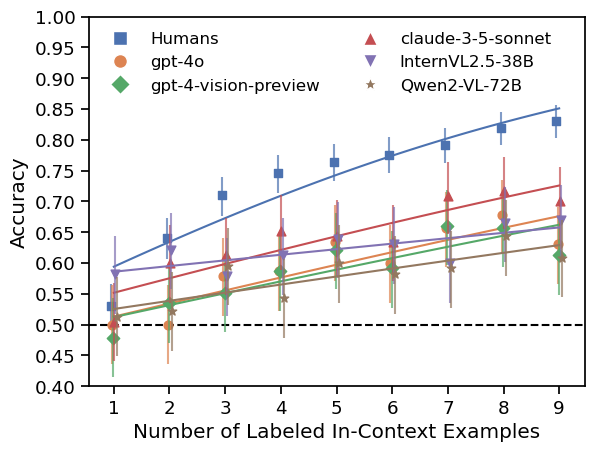

In [22]:
# This uses binomial SE for both logistic curve and scatter plot (consistent)

import statsmodels.api as sm
from matplotlib.lines import Line2D

# # Function to calculate mean accuracy and binomial confidence intervals
# def summarize_data(df):
#     summary = df.groupby(['num_incontext', 'agent']).agg(
#         mean_accuracy=('accuracy', 'mean'),
#         count=('accuracy', 'size')
#     ).reset_index()

#     # Calculate standard error for binomial distribution
#     summary['standard_error'] = np.sqrt(summary['mean_accuracy'] * (1 - summary['mean_accuracy']) / summary['count'])
#     return summary
# Function to calculate mean accuracy and proportion confidence intervals
def summarize_data(df):
    summary = df.groupby(['num_incontext', 'agent']).agg(
        mean_accuracy=('accuracy', 'mean'),
        count=('accuracy', 'size')
    ).reset_index()

    # Calculate confidence intervals using proportion_confint
    summary['lower'], summary['upper'] = zip(*summary.apply(
        lambda row: proportion_confint(row['mean_accuracy'] * row['count'], row['count'], alpha=0.05, method='wilson'), axis=1
    ))

    # Compute error bars (difference between mean and lower/upper bounds)
    summary['lower_error'] = summary['mean_accuracy'] - summary['lower']
    summary['upper_error'] = summary['upper'] - summary['mean_accuracy']
    
    return summary

# Calculate summarized data
summary = summarize_data(all_logistic)

# Plotting
plt.figure(figsize=(6.4, 4.8))
sns.set_context('notebook', font_scale=1.2)

# Unique agents and their properties
agents = summary['agent'].unique()
num_agents = len(agents)
colors = sns.color_palette('deep')[:num_agents]
markers = ['s', 'o', 'D', '^', 'v', '*']
offsets = np.linspace(-0.05, 0.05, num_agents)  # Offsets to separate error bars

# Custom legend handles
handles = []

for agent, color, marker, offset in zip(agents, colors, markers, offsets):

    # Subset summary for the agent
    subset = summary[summary.agent == agent]
    
    # Apply offset to num_incontext for plotting both points and error bars
    adjusted_x = subset['num_incontext'] + offset
    
    # Plot points with offset
    plt.scatter(adjusted_x, subset['mean_accuracy'], color=color, marker=marker, zorder=2, s=40)
    
    # Fit logistic regression manually
    X = sm.add_constant(subset['num_incontext'])
    y = subset['mean_accuracy']
    logit_model = sm.Logit(y, X).fit(disp=False)
    
    # Generate predictions and standard errors
    x_pred = np.linspace(subset['num_incontext'].min(), subset['num_incontext'].max(), 100)
    X_pred = sm.add_constant(x_pred)
    y_pred = logit_model.predict(X_pred)
    
    # Calculate confidence intervals for logistic regression predictions using proportion_confint
    y_pred_count = subset['count'].mean()  # Approximate mean count for SE calculation
    lower_pred, upper_pred = zip(*[proportion_confint(p * y_pred_count, y_pred_count, alpha=0.05, method='wilson') for p in y_pred])
    
    # Plot logistic regression line (smooth)
    plt.plot(x_pred, y_pred, color=color, zorder=2)
    plt.ylim( (0.4, 1))
    plt.xticks( range(1,10))
    plt.yticks( np.arange(0.4, 1.05, 0.05))
    
    # # Plot confidence interval bands (smooth) using fill_between
    # plt.fill_between(x_pred, lower_pred, upper_pred, color=color, alpha=0.2, zorder=3)
    
    # Plot error bars with the same offset and confidence intervals
    plt.errorbar(adjusted_x, subset['mean_accuracy'], 
                 yerr=[subset['lower_error'], subset['upper_error']], 
                 fmt='none', ecolor=color, alpha=0.7, zorder=2, label='_no_legend_')
    
    # Create custom legend handle
    handles.append(Line2D([0], [0], marker=marker, color='w', label=agent,
                          markerfacecolor=color, markersize=10))

plt.axhline(y=0.5, linestyle='--', c='black', zorder=1)
plt.xlabel('Number of Labeled In-Context Examples')
plt.ylabel('Accuracy')
plt.legend(handles=handles, loc='upper left', fontsize='small', ncol=2).get_frame().set_linewidth(0.0)
plt.show()

In [14]:
def get_num_objects(problem):
    dict_num_objects = {
        1: 2,
        2: 2,
        3: 4,
        4: 2,
        5: 4,
        6: 4,
        7: 6, 
        8: 2,
        9: 3,
        10: 4,
        11: 2,
        12: 3,
        13: 4,
        14: 3,
        15: 4,
        16: 6,
        17: 4,
        18: 6,
        19: 2,
        20: 2,
        21: 2,
        22: 3,
        23: 3
    }
    return dict_num_objects[problem]

all_logistic['num_objects'] = [get_num_objects(problem) for problem in all_logistic.problem]
all_logistic.head()

/tmp/ipykernel_1262856/1603269390.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_logistic['num_objects'] = [get_num_objects(problem) for problem in all_logistic.problem]


,problem,num_incontext,attempt,accuracy,agent,cot,num_objects
0,1.0,1.0,1,1.0,gpt-4o,Chain of Thought 0,2
1,1.0,1.0,2,1.0,gpt-4o,Chain of Thought 0,2
2,1.0,1.0,3,1.0,gpt-4o,Chain of Thought 0,2
3,1.0,1.0,4,0.0,gpt-4o,Chain of Thought 0,2
4,1.0,1.0,5,0.0,gpt-4o,Chain of Thought 0,2


/tmp/ipykernel_1262856/416939433.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(['num_objects', 'agent']).agg(


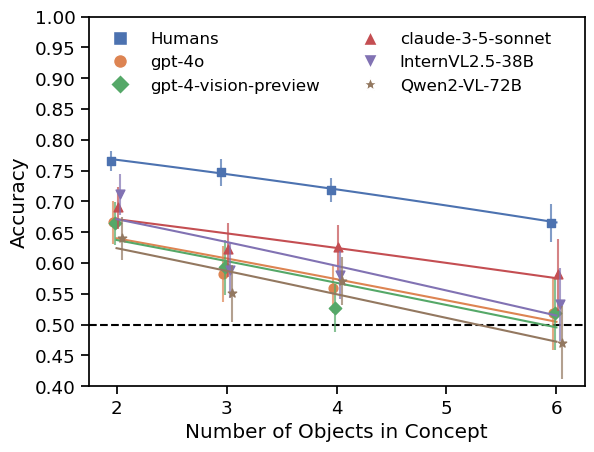

In [23]:
# Function to calculate mean accuracy and proportion confidence intervals
def summarize_data(df):
    summary = df.groupby(['num_objects', 'agent']).agg(
        mean_accuracy=('accuracy', 'mean'),
        count=('accuracy', 'size')
    ).reset_index()

    # Calculate confidence intervals using proportion_confint
    summary['lower'], summary['upper'] = zip(*summary.apply(
        lambda row: proportion_confint(row['mean_accuracy'] * row['count'], row['count'], alpha=0.05, method='wilson'), axis=1
    ))

    # Compute error bars (difference between mean and lower/upper bounds)
    summary['lower_error'] = summary['mean_accuracy'] - summary['lower']
    summary['upper_error'] = summary['upper'] - summary['mean_accuracy']
    
    return summary

# Calculate summarized data
summary = summarize_data(all_logistic)

# Plotting
plt.figure(figsize = (6.4, 4.8))
sns.set_context('notebook', font_scale=1.2)

# Unique agents and their properties
agents = summary['agent'].unique()
num_agents = len(agents)
colors = sns.color_palette('deep')[:num_agents]
markers = ['s', 'o', 'D', '^', 'v', '*']
offsets = np.linspace(-0.05, 0.05, num_agents)  # Offsets to separate error bars

# Custom legend handles
handles = []
    
for agent, color, marker, offset in zip(agents, colors, markers, offsets):

    # Subset summary for the agent
    subset = summary[summary.agent == agent]
    
    # Apply offset to num_objects for plotting both points and error bars
    adjusted_x = subset['num_objects'] + offset
    
    # Plot points with offset
    plt.scatter(adjusted_x, subset['mean_accuracy'], color=color, marker=marker, zorder=2, s=40)
    
    # Fit logistic regression manually
    X = sm.add_constant(subset['num_objects'])
    y = subset['mean_accuracy']
    logit_model = sm.Logit(y, X).fit(disp=False)
    
    # Generate predictions and standard errors
    x_pred = np.linspace(subset['num_objects'].min(), subset['num_objects'].max(), 100)
    X_pred = sm.add_constant(x_pred)
    y_pred = logit_model.predict(X_pred)
    
    # Calculate confidence intervals for logistic regression predictions using proportion_confint
    y_pred_count = subset['count'].mean()  # Approximate mean count for SE calculation
    lower_pred, upper_pred = zip(*[proportion_confint(p * y_pred_count, y_pred_count, alpha=0.05, method='wilson') for p in y_pred])
    
    # Plot logistic regression line (smooth)
    plt.plot(x_pred, y_pred, color=color, zorder=2)
    plt.ylim( (0.4, 1))
    plt.xticks( range(1,10))
    plt.yticks( np.arange(0.4, 1.05, 0.05))
    
    # # Plot confidence interval bands (smooth) using fill_between
    # plt.fill_between(x_pred, lower_pred, upper_pred, color=color, alpha=0.2, zorder=3)
    
    # Plot error bars with the same offset and confidence intervals
    plt.errorbar(adjusted_x, subset['mean_accuracy'], 
                 yerr=[subset['lower_error'], subset['upper_error']], 
                 fmt='none', ecolor=color, alpha=0.7, zorder=2, label='_no_legend_')
    
    # Create custom legend handle
    handles.append(Line2D([0], [0], marker=marker, color='w', label=agent,
                          markerfacecolor=color, markersize=10))

plt.axhline(y=0.5, c='black', linestyle='--', zorder=1)
plt.xlabel('Number of Objects in Concept')
plt.ylabel('Accuracy')
plt.legend(handles = handles, loc='upper left', fontsize='small', ncol=2).get_frame().set_linewidth(0.0)
plt.show()

In [24]:
# Save
all_logistic.to_csv('analysis/svrt_fewshot_allagents.csv')

# Misc

In [36]:
print(sns.color_palette("deep"))
sns.color_palette("deep")

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.5058823529411764, 0.4470588235294118, 0.7019607843137254), (0.5764705882352941, 0.47058823529411764, 0.3764705882352941), (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), (0.5490196078431373, 0.5490196078431373, 0.5490196078431373), (0.8, 0.7254901960784313, 0.4549019607843137), (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]